In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
i = 20
#switching latex fonts
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": 'fantasy',
#     "font.fantasy": ['Arial', 'Times New Roman', 'Tahoma']})
plt.rcParams.update({
    "figure.figsize": (16, 10)
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(value)
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({int(value, digit_number)} \u00B1 {int(error, digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{int(value, digit_number)} \u00B1 {int(error, digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"

def lower_upper_limits(domain, fun, popt, err, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)
    df = np.expand_dims(f(domain, *popt), 1) - f(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    sigm_f = np.sqrt(np.sum(df**2, 1))
    return (f(domain, *popt)-nsigma*sigm_f, f(domain, *popt)+nsigma*sigm_f)

In [61]:

def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

In [57]:
#ВВод данных
x = np.array([
256.0,361.0,484.0,625.0,784.0,961.0,1156.0,1521.0,1764.0,2025.0,2304.0,169.0
])
y = np.array([
40.474485,44.28800000000001,48.672000000000004,53.59786801199999,59.56816728,66.195521388,73.25249903999999,86.71392784400001,95.503225823,105.05186009,115.60976497600001,36.62553387599999
])
xerr = np.array([
32.0,38.0,44.0,50.0,56.0,62.0,68.0,78.0,84.0,90.0,96.0,26.0
])
yerr = np.array([
3.2584050000000007,3.113600000000001,3.0576000000000003,3.05875596,3.1154905600000005,3.2047047600000003,3.3160478399999995,3.5470028900000004,3.70314741,3.8748144900000008,4.058298240000001,3.569614409999999
])


0.03672112074944038 +- 0.001520303510828269
30.825715938287157 +- 1.7275667911026313


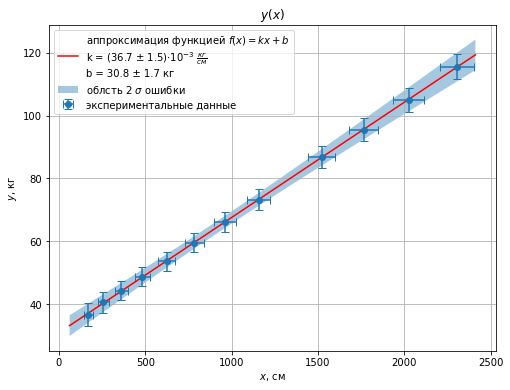

In [62]:
#xi square approximation with Y-errors
%matplotlib inline
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
нагвание графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
par_names = r'''
k, $\frac{кг}{см}$
b, кг
'''
# function to approximate
fun_name = "$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(r"$x$, см")
plt.ylabel(r"$y$, кг")
plt.title(r"$y(x)$")
plt.legend()

plt.savefig(f"opt{i}.png", dpi=200)
i+=1

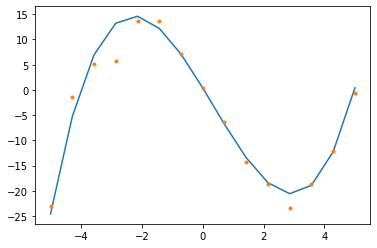

In [26]:
# data generation

def cub(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d
true_params = [0.5, -0.5, -10, 0.4]
x = np.linspace(-5, 5, 15)
error = 0.5
y = cub(x, *true_params)
noize = (np.random.normal(0, error, x.size))*np.mean(y)
y += noize
plt.plot(x, cub(x, *true_params)) 
plt.plot(x, y, '.') 

In [27]:
popt, pcov = curve_fit(cub, x, y)
X = np.linspace(x.min(), x.max(), teorPoints)

In [31]:
domain, fun, popt = X, cub, popt
cov = pcov

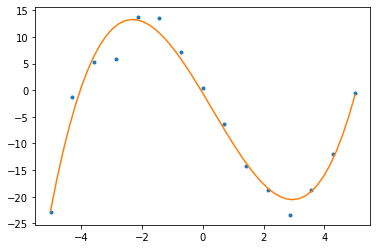

In [32]:
plt.plot(x, y, '.')
plt.plot(X, fun(X, *popt))

In [33]:
cov

array([[ 8.88160872e-04, -3.48555804e-10, -1.51349863e-02,
         5.91742739e-09],
       [-3.48555804e-10,  6.29221862e-03,  6.81195114e-09,
        -5.99258900e-02],
       [-1.51349863e-02,  6.81195114e-09,  3.05211168e-01,
        -1.14969439e-07],
       [ 5.91742739e-09, -5.99258900e-02, -1.14969439e-07,
         1.02118599e+00]])

In [22]:
dfk = fun(domain, popt[0] + np.sqrt(cov[0, 0]), popt[1]) - fun(domain, popt[0], popt[1])
dfb = fun(domain, popt[0], popt[1] + np.sqrt(cov[1, 1])) - fun(domain, popt[0], popt[1])
df2 = dfk**2 + 2*dfk*dfb*cov[0, 1]/np.sqrt(cov[0, 0]*cov[1, 1]) + dfb**2

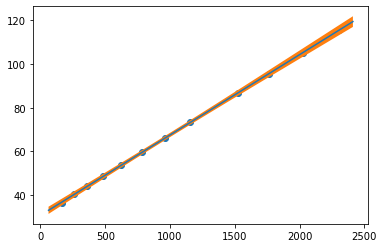

In [23]:
plt.scatter(x, y)
plt.plot(X, f(X, *popt))
plt.fill_between(X, f(X, *popt) + np.sqrt(df2),  f(X, *popt) - np.sqrt(df2))
# plt.plot(X, np.sqrt(df2)*10)

In [36]:
df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(np.sqrt(np.diag(pcov)), 1)))


In [37]:
df1 = df[0]
df1

array([ 3.7252535 , -1.98308765,  2.762296  , -1.01053748])

In [39]:
err = np.sqrt(np.diag(pcov))
corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
corr

array([[ 1.00000000e+00, -1.47443149e-07, -9.19255004e-01,
         1.96487395e-07],
       [-1.47443149e-07,  1.00000000e+00,  1.55442371e-07,
        -7.47584290e-01],
       [-9.19255004e-01,  1.55442371e-07,  1.00000000e+00,
        -2.05934816e-07],
       [ 1.96487395e-07, -7.47584290e-01, -2.05934816e-07,
         1.00000000e+00]])

In [47]:
dfmatrix = np.expand_dims(df1, 0)*np.expand_dims(df1, 1) * corr
np.sum(dfmatrix)
dfmatrixes = np.array([dfmatrix, dfmatrix, dfmatrix, dfmatrix])
np.sum(dfmatrixes, axis=(1, 2))


In [50]:
dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
sigma_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))

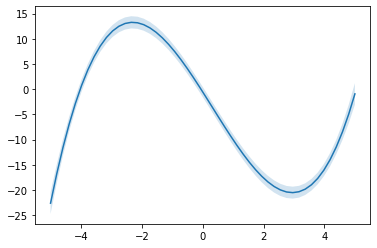

In [53]:
plt.plot(X, fun(X, *popt))
plt.fill_between(X, fun(X, *popt)+sigma_f, fun(X, *popt)-sigma_f, alpha=0.2)